In [1]:
import mlx.core as mx
import mlx.optimizers as optim
import mlx.nn as nn
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from mlx_gpt2 import GPTModel, create_dataloader_v1, train_model_simple, token_ids_to_text, text_to_token_ids, generate_text_simple, calc_loss_loader

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["label", "text"])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
print(df["label"].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [5]:
def create_balanced_dataset(df):

    # count the instances of "spam":
    num_spam = df[df["label"] == "spam"].shape[0]

    # randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["label"] =="ham"].sample(num_spam, random_state=123)
    
    # concat ham_subset with spam
    balanced_df = pd.concat([ham_subset, df[df["label"] == "spam"]])
    return balanced_df

#balanced_df = create_balanced_dataset(df)
#print(balanced_df["label"].value_counts())

In [6]:
#balanced_df["label"] = balanced_df["label"].map({"ham": 0, "spam": 1})
df["label"] = df["label"].map({"ham": 0, "spam": 1})

In [7]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

# train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df, validation_df, test_df = random_split(df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [8]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [9]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [10]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=256,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

256


In [11]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [13]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 256])
Label batch dimensions torch.Size([8])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

487 training batches
70 validation batches
140 test batches


In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,  # Context length
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [16]:
print(BASE_CONFIG)

{'vocab_size': 50257, 'context_length': 256, 'drop_rate': 0.1, 'qkv_bias': False, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12}


In [17]:
mx.random.seed(123)
model = GPTModel(BASE_CONFIG)
model.load_weights("gpt2_shakespeare_ft.safetensors")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.09999999999999998)
  (trf_blocks): Sequential(
    (layers.0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(input_dims=768, output_dims=768, bias=False)
        (W_key): Linear(input_dims=768, output_dims=768, bias=False)
        (W_value): Linear(input_dims=768, output_dims=768, bias=False)
        (out_proj): Linear(input_dims=768, output_dims=768, bias=True)
        (dropout): Dropout(p=0.09999999999999998)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (layers.0): Linear(input_dims=768, output_dims=3072, bias=True)
          (layers.1): GELU()
          (layers.2): Linear(input_dims=3072, output_dims=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.09999999999999998)
    )
    (layers.1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_que

In [18]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'
But the sea,
But from this, nor beauty was on the time's beauty's hand.
But


In [19]:
model.freeze()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.09999999999999998)
  (trf_blocks): Sequential(
    (layers.0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(input_dims=768, output_dims=768, bias=False)
        (W_key): Linear(input_dims=768, output_dims=768, bias=False)
        (W_value): Linear(input_dims=768, output_dims=768, bias=False)
        (out_proj): Linear(input_dims=768, output_dims=768, bias=True)
        (dropout): Dropout(p=0.09999999999999998)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (layers.0): Linear(input_dims=768, output_dims=3072, bias=True)
          (layers.1): GELU()
          (layers.2): Linear(input_dims=3072, output_dims=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.09999999999999998)
    )
    (layers.1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_que

In [20]:
model.out_head.weight.shape

(50257, 768)

In [20]:
mx.random.seed(123)

num_classes = 2
model.out_head = nn.Linear(BASE_CONFIG["emb_dim"], num_classes)

In [21]:
model.trf_blocks.layers[-1].unfreeze()
model.final_norm.unfreeze()

LayerNorm()

In [22]:
inputs = tokenizer.encode("Do you have time")
inputs = mx.expand_dims(mx.array(inputs), 0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: array([[5211, 345, 423, 640]], dtype=int32)
Inputs dimensions: (1, 4)


In [23]:
outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 array([[[-0.390748, -0.0237273],
        [-0.404553, -0.531562],
        [-0.188375, 0.181272],
        [-0.155187, 0.325376]]], dtype=float32)
Outputs dimensions: (1, 4, 2)


In [24]:
print("Last output token:", outputs[:, -1, :])

Last output token: array([[-0.155187, 0.325376]], dtype=float32)


In [25]:
probas = mx.softmax(outputs[:, -1, :], axis=-1)
label = mx.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [26]:
def calc_accuracy_loader(data_loader, model, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = mx.array(input_batch.numpy()), mx.array(target_batch.numpy())

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = mx.argmax(logits, axis=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [27]:
mx.random.seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 25.00%
Validation accuracy: 38.75%
Test accuracy: 26.25%


In [28]:
def calc_loss_batch(model, input_batch, target_batch):
    input_batch, target_batch
    #print("input_batch shape:", input_batch.shape)
    #print("target_batch shape:", target_batch.shape)
    #print("input_batch:", input_batch)
    #print("target_batch:", target_batch)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    #print("logits shape:", logits.shape)
    #print("logits:", logits)
    return mx.mean(nn.losses.cross_entropy(mx.softmax(logits, axis=-1), target_batch))

In [29]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(model, mx.array(input_batch.numpy()), mx.array(target_batch.numpy()))
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [30]:
train_loss = calc_loss_loader(train_loader, model, num_batches=5)
val_loss = calc_loss_loader(val_loader, model, num_batches=5)
test_loss = calc_loss_loader(test_loader, model, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.780
Validation loss: 0.769
Test loss: 0.752


In [31]:
def train_classifier_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    num_epochs,
    eval_freq,
    eval_iter,
    tokenizer,
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    loss_and_grad_fn = nn.value_and_grad(model, calc_loss_batch)

    for epoch in range(num_epochs):
        for input_batch, target_batch in train_loader:
            input_batch = mx.array(input_batch.numpy())
            target_batch = mx.array(target_batch.numpy())
            loss, grads = loss_and_grad_fn(model, input_batch, target_batch)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)

            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [32]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, eval_iter):
    model.eval()
    train_loss = calc_loss_loader(train_loader, model, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [33]:
import time

start_time = time.time()

mx.random.seed(123)

optimizer = optim.AdamW(
    learning_rate=optim.linear_schedule(0.0, 0.0002, 50), weight_decay=0.1
)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.743, Val loss 0.769
Ep 1 (Step 000050): Train loss 0.313, Val loss 0.513
Ep 1 (Step 000100): Train loss 0.363, Val loss 0.513
Ep 1 (Step 000150): Train loss 0.488, Val loss 0.513
Ep 1 (Step 000200): Train loss 0.463, Val loss 0.513
Ep 1 (Step 000250): Train loss 0.488, Val loss 0.513
Ep 1 (Step 000300): Train loss 0.438, Val loss 0.513
Ep 1 (Step 000350): Train loss 0.588, Val loss 0.513
Ep 1 (Step 000400): Train loss 0.438, Val loss 0.513
Ep 1 (Step 000450): Train loss 0.413, Val loss 0.513
Training accuracy: 80.00% | Validation accuracy: 80.00%
Ep 2 (Step 000500): Train loss 0.438, Val loss 0.513
Ep 2 (Step 000550): Train loss 0.413, Val loss 0.513
Ep 2 (Step 000600): Train loss 0.388, Val loss 0.513
Ep 2 (Step 000650): Train loss 0.438, Val loss 0.513
Ep 2 (Step 000700): Train loss 0.463, Val loss 0.513
Ep 2 (Step 000750): Train loss 0.463, Val loss 0.513
Ep 2 (Step 000800): Train loss 0.463, Val loss 0.513
Ep 2 (Step 000850): Train loss 0.463, Val l

In [34]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

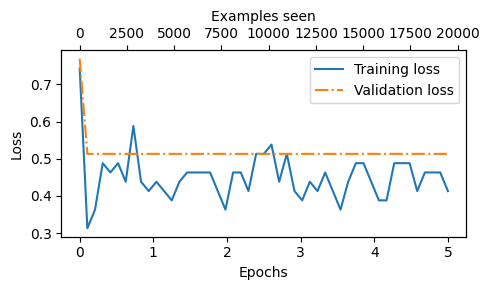

In [35]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

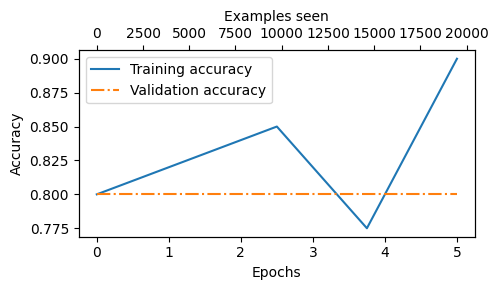

In [36]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [37]:
train_accuracy = calc_accuracy_loader(train_loader, model)
val_accuracy = calc_accuracy_loader(val_loader, model)
test_accuracy = calc_accuracy_loader(test_loader, model)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 86.47%
Validation accuracy: 87.61%
Test accuracy: 86.55%


In [38]:
model.save_weights("gpt2_classifier_ft.safetensors")

In [39]:
print(mx.softmax(model(text_to_token_ids("You are a winner you have been specially selected to receive $1000 cash or a $2000 award.", tokenizer=tokenizer)), axis=-1))

array([[[0.998807, 0.00119307],
        [0.999998, 1.76092e-06],
        [0.999996, 3.54306e-06],
        ...,
        [1, 5.07349e-07],
        [1, 1.94025e-07],
        [0.999536, 0.000464052]]], dtype=float32)


In [40]:
def classify_review(text, model, tokenizer, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = mx.expand_dims(mx.array(input_ids), 0) # add batch dimension

    # Model inference
    logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = mx.argmax(logits, axis=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [41]:
text_1 = (
    "Text 123456 at 1-800-911-9111 for a free estimate."
)

print(classify_review(
    text_1, model, tokenizer, max_length=train_dataset.max_length
))

not spam
